## IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## DEFINING PATH FOR DATASET

In [2]:
image_path = r'C:\Data\SRI\Covid19 CT\ct_scans'
mask_path = r'C:\Data\SRI\Covid19 CT\lung_mask'

## GETTING TRAIN/VALIDATION/TEST DATA

In [3]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return(array)

In [4]:
image_path_list = os.listdir(image_path)

images = []
masks = []
for row in image_path_list:
    image_path1 = os.path.join(image_path, row)
    mask_path1 = os.path.join(mask_path, row)

    image_read = read_nii(image_path1)
    mask_read = read_nii(mask_path1) 
    
    image_final = cv2.resize(image_read, (128, 128))        
    mask_final = cv2.resize(mask_read, (128, 128))
        
    for i in range(image_final.shape[2]):
        temp_image = np.expand_dims(image_final[...,i], axis=-1)
    
        images.append(temp_image)
        masks.append(mask_final[...,i])

In [5]:
images = np.array(images)
masks = np.array(masks)

In [6]:
images = images/((images.max()) - (images.min()))

## TRAIN/VALIDATION/TEST SPLIT

In [7]:
x_train, test_images, y_train, test_masks = train_test_split(images, masks, test_size=0.2)

In [8]:
train_images, valid_images, train_masks, valid_masks = train_test_split(x_train, y_train, test_size=0.25)

## CONVOLUTION BLOCKS

In [9]:
#down sampling
def down_samp(x, filters):
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(x)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    p = keras.layers.MaxPooling2D((2, 2), (2, 2))(c)
    
    return c, p
    
#bottleneck 
def bottlenock(x, filters):
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(x)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    
    return c
    
#up sampling
def up_samp(x, skip, filters):
    us = keras.layers.UpSampling2D((2, 2))(x)
    conc = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(conc)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    
    return c

## UNET ARCHITECTURE

In [10]:
def unet():
    f = [8, 16, 32, 64, 128]
    
    inputs = keras.layers.Input((128, 128, 1))
    
    p0 = inputs
    c1, p1 = down_samp(p0, f[0])
    c2, p2 = down_samp(p1, f[1])
    c3, p3 = down_samp(p2, f[2])
    c4, p4 = down_samp(p3, f[3])
    
    bn = bottlenock(p4, f[4])
    
    d1 = up_samp(bn, c4, f[3])
    d2 = up_samp(d1, c3, f[2])
    d3 = up_samp(d2, c2, f[1])
    d4 = up_samp(d3, c1, f[0])
 
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="softmax")(d4)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [11]:
model = unet()
model.compile(optimizer="adam", 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## TRAINING THE UNET MODEL

In [13]:
model.fit(
    train_images,
    train_masks,
    epochs=5,
    validation_data=(valid_images, valid_masks)
)

Epoch 1/5
66/66 [==============================] - 136s 2s/step - loss: 0.5177 - accuracy: 0.8863 - val_loss: 0.2819 - val_accuracy: 0.8989
Epoch 2/5
66/66 [==============================] - 127s 2s/step - loss: 0.2485 - accuracy: 0.8981 - val_loss: 0.2145 - val_accuracy: 0.8989
Epoch 3/5
66/66 [==============================] - 125s 2s/step - loss: 0.1734 - accuracy: 0.8981 - val_loss: 0.1408 - val_accuracy: 0.8989
Epoch 4/5
66/66 [==============================] - 122s 2s/step - loss: 0.1272 - accuracy: 0.9305 - val_loss: 0.1276 - val_accuracy: 0.9353
Epoch 5/5
66/66 [==============================] - 124s 2s/step - loss: 0.0654 - accuracy: 0.9725 - val_loss: 0.0329 - val_accuracy: 0.9868


## EVALUATION/PREDICTION ON TEST DATA

In [14]:
evalu = model.evaluate(test_images, test_masks, verbose=0)
print('The accuracy of model on Test Data-Set is = '"{:.2f}".format(evalu[1]*100), '%')

The accuracy of model on Test Data-Set is = 98.66 %


In [15]:
results_temp = model.predict(test_images)
results = np.argmax(results_temp, axis=3)

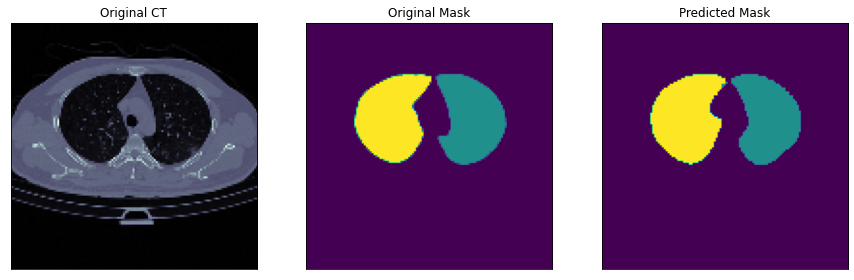

In [17]:
plt.figure(figsize = (15, 15))
    
plt.subplot(1, 3, 1)
plt.xticks([]) 
plt.yticks([]) 
plt.grid(False)
plt.imshow(test_images[300], cmap='bone')
plt.title('Original CT')

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_masks[300])
plt.title('Original Mask')

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(results[300])
plt.title('Predicted Mask')

plt.show()